In [ ]:
# Projeto Marinha do Brasil

# Autor: Natanael Junior (natmourajr@gmail.com)
# Laboratorio de Processamento de Sinais - UFRJ

In [6]:
import os
import pickle
import numpy as np
import time

init_time = time.time()

from sklearn import preprocessing
from sklearn import cross_validation
from sklearn import svm
from sklearn.decomposition import PCA
from sklearn.externals import joblib

import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerLine2D

plt.rcParams['lines.linewidth'] = 2
plt.rcParams['legend.handlelength'] = 3
plt.rcParams['legend.borderpad'] = 0.3
plt.rcParams['legend.numpoints'] = 1
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['ytick.labelsize'] = 18

%matplotlib inline

import scipy.stats as sp_stats

m_time = time.time()
print 'Time to import all libraries: '+str(m_time-init_time)+' seconds'

outputpath = os.environ['OUTPUTDATAPATH']
main_analysis_path = os.environ['SONAR_WORKSPACE']
log_analysis_path = os.environ['PACKAGE_OUTPUT']
result_analysis_path = os.environ['PACKAGE_OUTPUT']+'/PCASingleClassSVM'
# Read data
# Check if LofarData has created...
m_time = time.time()


subfolder = '4classes'
n_pts_fft = 1024
decimation_rate = 3

if(not os.path.exists(outputpath+'/'+'LofarData_%s_%i_fft_pts_%i_decimation_rate.jbl'%(
            subfolder,n_pts_fft,decimation_rate))):
    print outputpath+'/'+'LofarData_%s_%i_fft_pts_%i_decimation_rate.jbl'%(
        subfolder,n_pts_fft,decimation_rate)+' doesnt exist...please create it'
    exit()
    
#Read lofar data
[data,class_labels] = joblib.load(outputpath+'/'+'LofarData_%s_%i_fft_pts_%i_decimation_rate.jbl'%(
            subfolder,n_pts_fft,decimation_rate))
m_time = time.time()-m_time
print 'Time to read data file: '+str(m_time)+' seconds'

Time to import all libraries: 0.00340390205383 seconds
Time to read data file: 1.66802191734 seconds


In [19]:
# Read log files
from Functions import LogFunctions as log
mlog = log.LogInformation()
log_entries = mlog.RecoverLogEntries("NoveltyDetection")
print log_entries

{0: {'date': '2016_12_01_17_27_33', 'package': 'PCASingleClassSVM'}, 1: {'date': '2016_12_01_17_51_48', 'package': 'PCASingleClassSVM'}, 2: {'date': '2016_12_01_18_09_34', 'package': 'PCASingleClassSVM'}, 3: {'date': '2016_12_01_18_25_15', 'package': 'PCASingleClassSVM'}, 4: {'date': '2016_12_01_19_09_08', 'package': 'PCASingleClassSVM'}}


# Novelty Analysis Analysis


## Efficiency plot
This plot has the propuse to show the efficiency for each class and for novelty detection per $\nu$ value

Analysing train performed in 2016_12_01_17_51_48 and for PCASingleClassSVM analysis


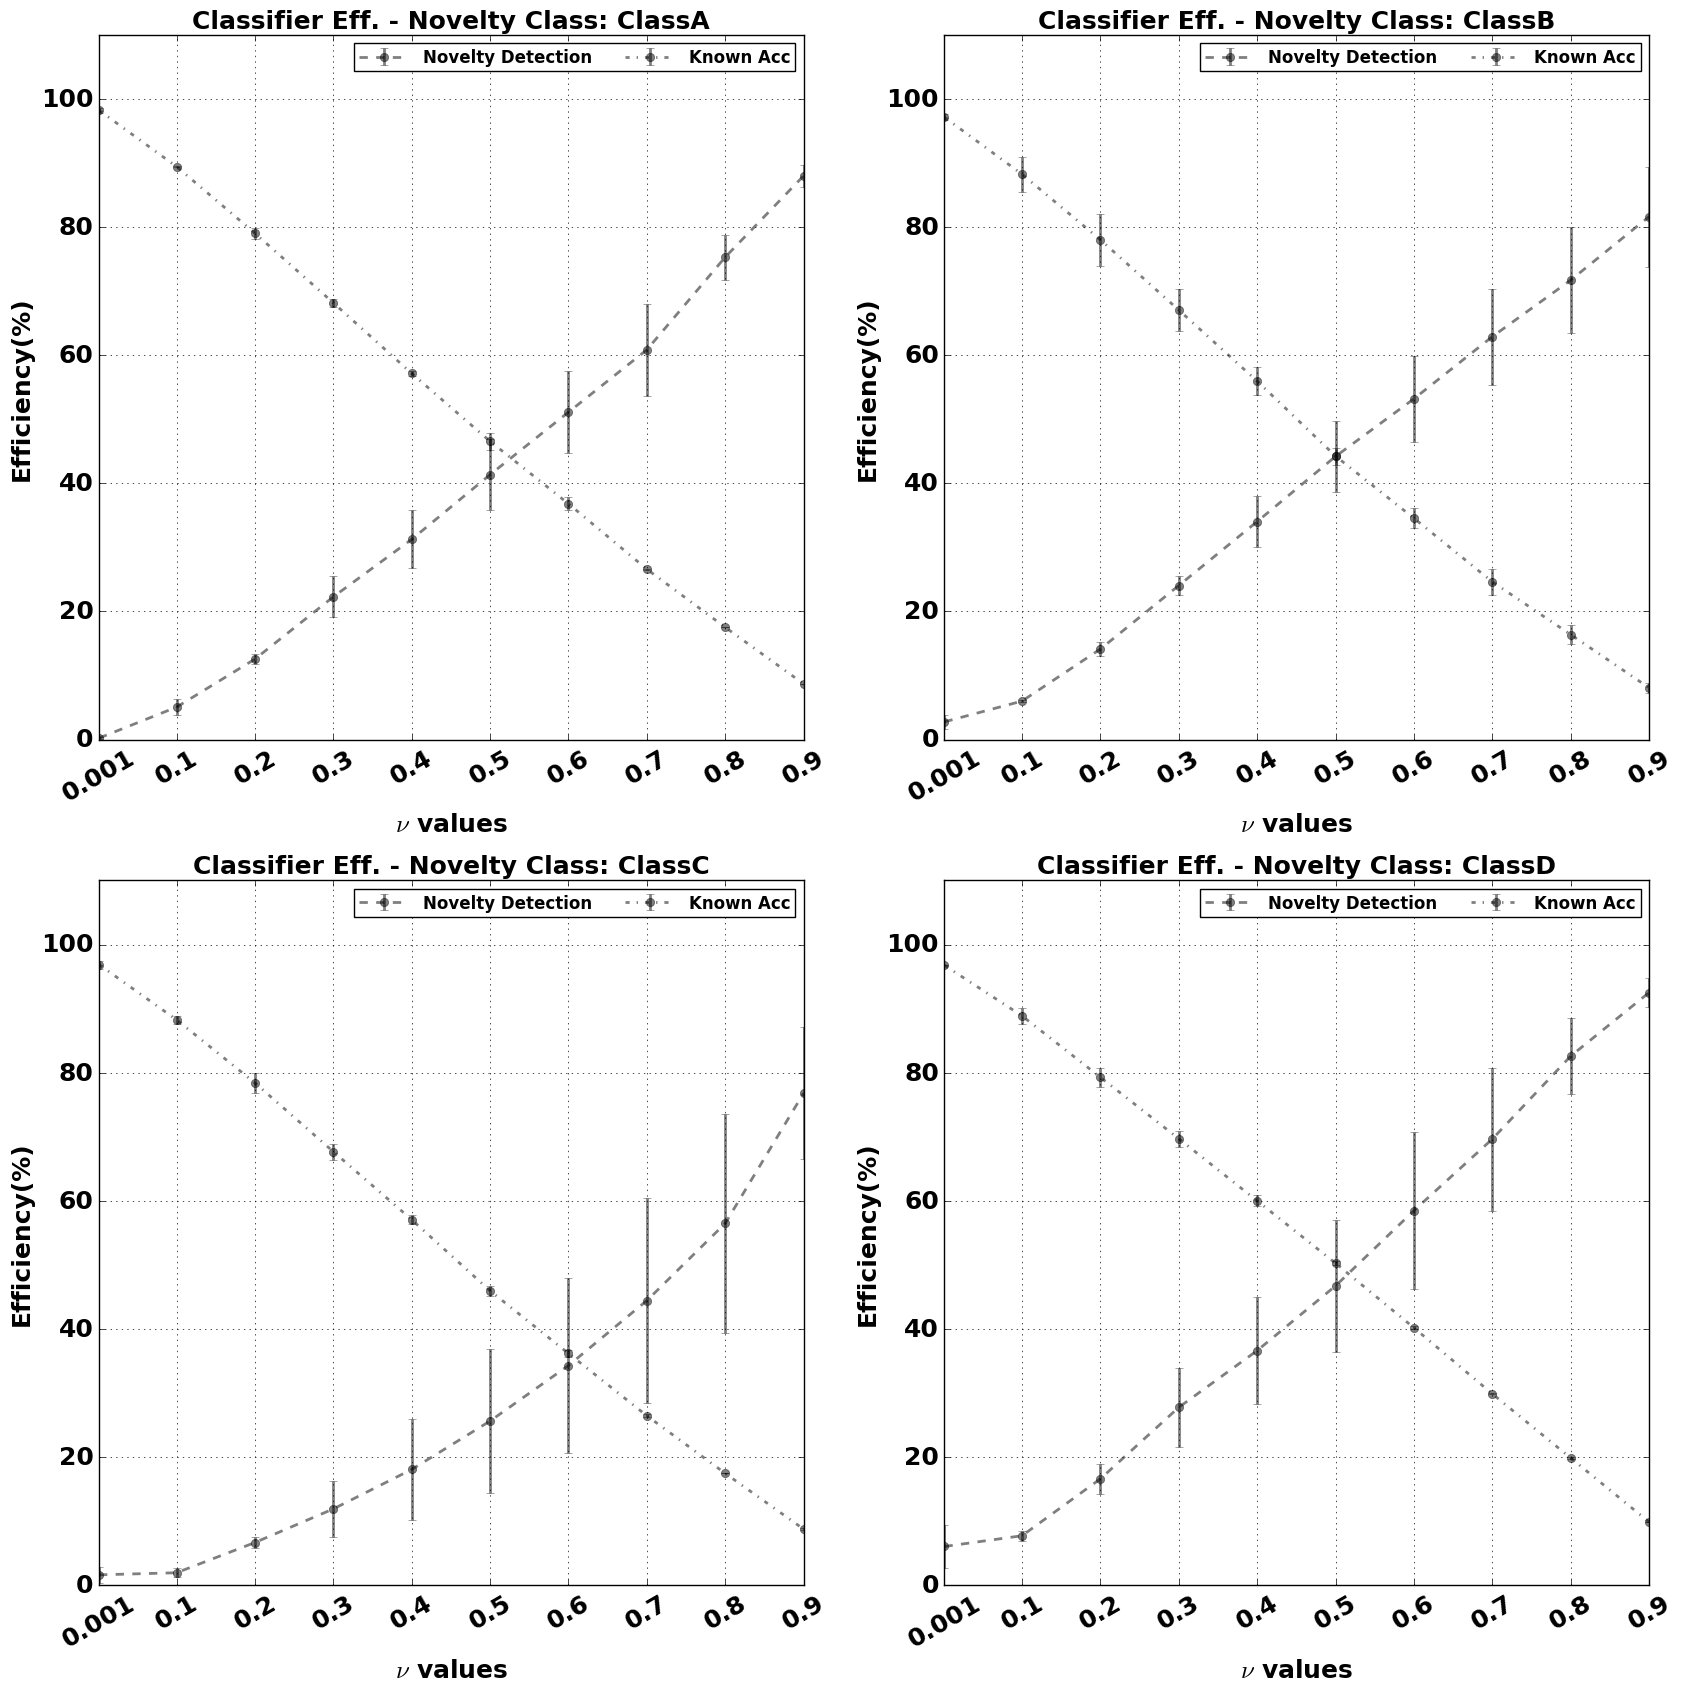

In [23]:
# Read log files
from Functions import LogFunctions as log
mlog = log.LogInformation()
log_entries = mlog.RecoverLogEntries("NoveltyDetection")

choose_date = '2016_12_01_17_51_48'

for log_id, log_entry in enumerate(log_entries):
    if log_entries[log_id]['package'] != 'PCASingleClassSVM':
        continue
    if log_entries[log_id]['date'] != choose_date:
        continue
    print 'Analysing train performed in %s and for %s analysis'%(
        log_entries[log_id]['date'],log_entries[log_id]['package'])
    
    # Read train info file
    train_info_name = '%s/train_info_files/%s_train_info.jbl'%(
        result_analysis_path,log_entries[log_id]['date'])
    # Read Result info file
    result_base_name = '%s/result_files'%(result_analysis_path)
    picts_base_name = '%s/picts'%(result_analysis_path)
    
    # check if the train file exists
    if(not os.path.exists(train_info_name)):
        print 'The file %s does not exist, please create it...'%(train_info_name)
    else:
        # if file exists, do the analysis
        results = {}
        [train_info] = joblib.load(train_info_name)
        for novelty_class, novelty_label in enumerate(class_labels):
            results[novelty_label] = {}
            for iclass, class_label in enumerate(class_labels):
                if novelty_class == iclass: continue
                results[novelty_label][class_label] = np.zeros([len(train_info['nu_values']),
                                                                len(train_info['CVO_%s'%(novelty_label)])])
            results[novelty_label]['Novelty Detector'] = np.zeros([len(train_info['nu_values']),
                                                                   len(train_info['CVO_%s'%(novelty_label)])])
            results[novelty_label]['Accuracy'] = np.zeros([len(train_info['nu_values']),
                                                                   len(train_info['CVO_%s'%(novelty_label)])])
            results[novelty_label]['Trigger'] = np.zeros([len(train_info['nu_values']),
                                                                   len(train_info['CVO_%s'%(novelty_label)])])
            
            for nu_id, nu_value in enumerate(train_info['nu_values']):
                for ifold in range(len(train_info['CVO_%s'%(novelty_label)])):
                    #print "Recovering for Novelty %s - fold %i of %i, Nu value: %f"%(
                     #   novelty_label,ifold,len(train_info['CVO_%s'%(novelty_label)]),nu_value)
                    results_file = np.loadtxt('%s/%s_%s_novelty_%i_fold_%f_nu.txt'%
                                (result_base_name, log_entries[log_id]['date'],novelty_label,ifold,nu_value))
                    # compute class eff
                    total_known_correct_events = 0
                    total_known_events = 0;
                    for iclass, class_label in enumerate(class_labels):
                        if iclass == novelty_class: continue
                        total_known_correct_events = (total_known_correct_events+
                                                      float(sum(results_file[results_file[:,4]==iclass,
                                                                iclass-(iclass>novelty_class)]>0)))
                        total_known_events = total_known_events+float(sum(results_file[:,4]==iclass))
                        results[novelty_label][class_label][nu_id,ifold] = (
                            float(sum(results_file[results_file[:,4]==iclass,iclass-(iclass>novelty_class)]>0))/
                                                                            sum(results_file[:,4]==iclass))
                    results[novelty_label]['Novelty Detector'][nu_id,ifold] = (
                        float(sum(results_file[results_file[:,4]==novelty_class,3]<0))/
                                                                    sum(results_file[:,4]==novelty_class))
                    results[novelty_label]['Accuracy'][nu_id,ifold] = (total_known_correct_events/
                                                                               total_known_events)
                    results[novelty_label]['Trigger'][nu_id,ifold] = (
                        float(sum(results_file[results_file[:,4]!=novelty_class,3]>0))/
                                                                    sum(results_file[:,4]!=novelty_class)) 
    # Plot Efficiency
    fig, subplot_array = plt.subplots(nrows=2, ncols=2,figsize=(20,20))
    m_colors = ['b', 'r', 'g', 'y']
    for novelty_class, novelty_label in enumerate(class_labels):
        ax = plt.subplot(2,2,novelty_class+1)
        m_fontsize = 18
        plt.title('Classifier Eff. - Novelty Class: '+novelty_label, fontsize= m_fontsize, fontweight="bold")
        if novelty_class > -1:
            plt.xlabel(r'$\nu$ values', fontsize= m_fontsize, fontweight="bold")
        plt.ylabel('Efficiency(%)', fontsize= m_fontsize, fontweight="bold")
        m_leg = []

        for iclass, class_label in enumerate(class_labels):
            if iclass == novelty_class: continue
        
            # creating vectors
            mean_eff = np.zeros_like(train_info['nu_values'])
            std_eff = np.zeros_like(train_info['nu_values'])
        
            for nu_id, nu_value in enumerate(train_info['nu_values']):
                mean_eff[nu_id] = np.mean(100*results[novelty_label][class_label][nu_id,:])
                std_eff[nu_id] = np.std(100*results[novelty_label][class_label][nu_id,:])
            #plt.errorbar(train_info['nu_values'],mean_eff,std_eff,marker='o',color=m_colors[iclass])
            #m_leg.append(class_label+' Eff.')
    
        mean_eff = np.zeros_like(train_info['nu_values'])
        std_eff = np.zeros_like(train_info['nu_values'])

        for nu_id, nu_value in enumerate(train_info['nu_values']):
            mean_eff[nu_id] = np.mean(100*results[novelty_label]['Novelty Detector'][nu_id,:])
            std_eff[nu_id] = np.std(100*results[novelty_label]['Novelty Detector'][nu_id,:])
        plt.errorbar(train_info['nu_values'],mean_eff,std_eff,marker='o',color='k',ls='--',alpha=0.5)
        m_leg.append('Novelty Detection')
    
        sp_vec = []
        for nu_id, nu_value in enumerate(train_info['nu_values']):
            eff_vec = []
            for iclass, class_label in enumerate(class_labels):
                if iclass == novelty_class: continue
                eff_vec.append(100*results[novelty_label][class_label][nu_id,:])
            sp_vec.append(np.sqrt(np.mean(eff_vec,axis=0)*sp_stats.gmean(eff_vec,axis=0)))
        
        #mean_sp = np.mean(sp_vec,axis=1)
        #std_sp = np.std(sp_vec,axis=1)
        #plt.errorbar(train_info['nu_values'],mean_sp,std_sp,marker='o',color='k',alpha=0.5)
        #m_leg.append('Known SP')
    
        mean_acc = np.mean(100*results[novelty_label]['Accuracy'],axis=1)
        std_acc = np.std(100*results[novelty_label]['Accuracy'],axis=1)
        plt.errorbar(train_info['nu_values'],mean_acc,std_acc,marker='o',color='k',ls='-.',alpha=0.5)
        m_leg.append('Known Acc')
    
        #mean_tri = np.mean(100*results[novelty_label]['Trigger'],axis=1)
        #std_tri = np.std(100*results[novelty_label]['Trigger'],axis=1)
        #plt.errorbar(train_info['nu_values'],mean_tri,std_tri,marker='o',color='k',ls=':',alpha=0.5)
        #m_leg.append('Known Trigger')
    
        m_x_labels = train_info['nu_values']
        
        # graphical assusts
        plt.xlim([np.min(m_x_labels), np.max(m_x_labels)])
        plt.ylim([0.0, 110])
        plt.xticks(m_x_labels,m_x_labels,rotation=30)
    
        plt.grid()
        plt.legend(m_leg, loc='upper right',ncol=2)
    pict_name = ('%s/%s_%s_eff_plot.pdf')%(picts_base_name,log_entries[log_id]['date'],
                                    log_entries[log_id]['package'])
    plt.savefig(pict_name)

This plot should be analysed

## Distributions Analysis
This part of analysis is dedicated to analyse distributions

### SVs KL Distributions
This plot will express the KL divergence between all the SVs for a specific $\nu$ value and specific fold

Analysing train performed in 2016_07_13_19_20_57 and for PCASingleClassSVM analysis


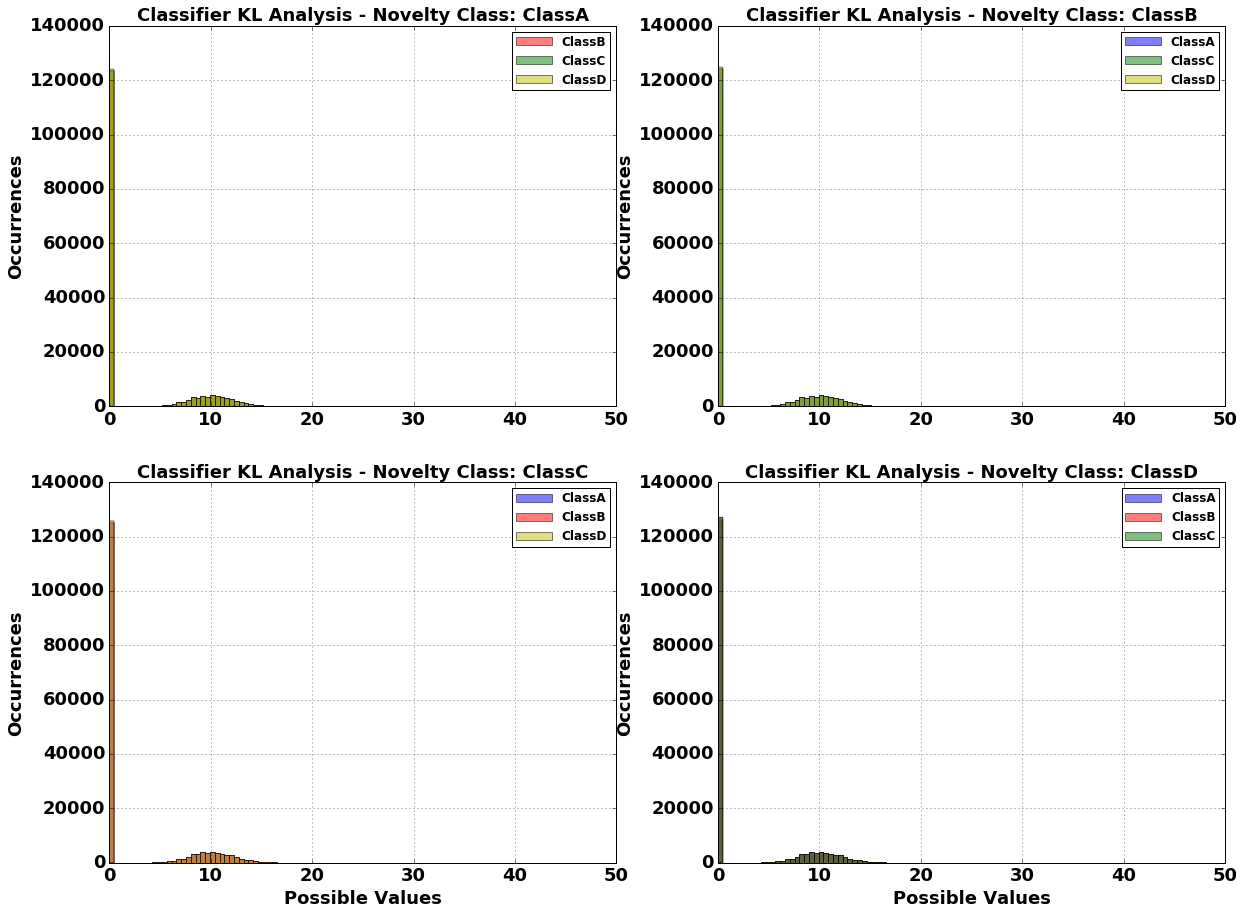

In [126]:
from Functions import StatFunctions as stats

# Read log files
from Functions import LogFunctions as log
mlog = log.LogInformation()
log_entries = mlog.RecoverLogEntries("NoveltyDetection")

choose_date = '2016_07_13_19_20_57'
choose_nu = 0.01
choose_fold = 0

n_bins = 100

for log_id, log_entry in enumerate(log_entries):
    if log_entries[log_id]['package'] != 'PCASingleClassSVM':
        continue
    if log_entries[log_id]['date'] != choose_date:
        continue
    print 'Analysing train performed in %s and for %s analysis'%(
        log_entries[log_id]['date'],log_entries[log_id]['package'])

    # Read train info file
    train_info_name = '%s/train_info_files/%s_train_info.jbl'%(
        result_analysis_path,log_entries[log_id]['date'])
    
    # check if the train file exists
    if(not os.path.exists(train_info_name)):
        print 'The file %s does not exist, please create it...'%(train_info_name)
    else:
        [train_info] = joblib.load(train_info_name)
        class_info_name = result_analysis_path+'/classifiers_files'+'/'+log_entries[log_id]['date']+'_classifiers.jbl'
        [classifiers] = joblib.load(class_info_name)
        
        fig, subplot_array = plt.subplots(nrows=2, ncols=2,figsize=(20,15))
        m_colors = ['b', 'r', 'g', 'y']
        
        for novelty_class, novelty_label in enumerate(class_labels):
            ax = plt.subplot(2,2,novelty_class+1)
            m_fontsize = 18
            plt.title('Classifier KL Analysis - Novelty Class: '+novelty_label, fontsize= m_fontsize, fontweight="bold")
            if novelty_class > 1:
                plt.xlabel('Possible Values', fontsize= m_fontsize, fontweight="bold")
            plt.ylabel('Occurrences', fontsize= m_fontsize, fontweight="bold")
            
            #data vectors
            known_data = {};
            # known classes loop
            for known_class, known_label in enumerate(class_labels):
                if known_class == novelty_class:continue
                # known class run loop
                for irun in range(len(data[known_class])):
                    if len(known_data) == 0:
                        known_data = data[known_class][irun]['Signal']
                        known_trgt = (known_class)*np.ones(data[known_class][irun]['Signal'].shape[1])
                    else:
                        known_data = np.append(known_data,data[known_class][irun]['Signal'],axis=1)
                        known_trgt = np.append(known_trgt,(known_class)*np.ones(
                                data[known_class][irun]['Signal'].shape[1]),axis=0)
            known_data = known_data.transpose()
    
            for ifold in range(len(train_info['CVO_%s'%(novelty_label)])):
                if ifold != choose_fold: continue
                train_id, test_id = train_info['CVO_%s'%(novelty_label)][ifold]
                for nu_id, nu_value in enumerate(train_info['nu_values']):
                    if nu_value != choose_nu: continue
                    kl_values = {}
                    for known_class, known_label in enumerate(class_labels):
                        if known_class == novelty_class: continue
                        kl_values[known_class-(known_class>novelty_class)] = []
                        class_idx = np.nonzero(known_trgt == known_class)[0]
                        idx = np.intersect1d(class_idx,train_id)
                        
                        sv_ids = classifiers[novelty_class][ifold][nu_value][known_label].support_
                        for isv, sv_value in enumerate(sv_ids):
                            if isv == 0: continue
                            id_pdf1 = sv_ids[isv-1]
                            id_pdf2 = sv_ids[isv]
                            pdf1 = known_data[idx[id_pdf1],:]
                            pdf2 = known_data[idx[id_pdf1],:]
                            
                            
                            [buff,kl_value] = stats.KLDiv(pdf1,pdf2)
                            kl = np.append(kl,buff)
                        kl_values[known_class-(known_class>novelty_class)] = kl
                    m_max = 0
                    m_min = 0
                    m_max = np.max([kl_values[0].max(),kl_values[1].max(),kl_values[2].max()])
                    m_min = np.min([kl_values[0].min(),kl_values[1].min(),kl_values[2].min()])
                    
                    m_bins = np.linspace(m_min, m_max,n_bins)
                    
                    for known_class, known_label in enumerate(class_labels):
                        if known_class == novelty_class: continue
                        n1, bins, patches = plt.hist(kl_values[known_class-(known_class>novelty_class)],
                                                     bins=m_bins,fc=m_colors[known_class],alpha=0.5,
                                                     label=known_label)
                    plt.grid()
                    plt.legend(loc='best')
        pict_name = ('%s/%s_%s_dist_plot_kl_svs_%i_fold_%f_nu.pdf')%(picts_base_name,log_entries[log_id]['date'],
                                    log_entries[log_id]['package'],choose_fold, choose_nu)
        plt.savefig(pict_name)               

This plot should be analysed

### Events Distance Distributions
This plot will express the distance between regular known events and separating hyperplane (known classifiers)

Analysing train performed in 2016_07_13_19_20_57 and for PCASingleClassSVM analysis


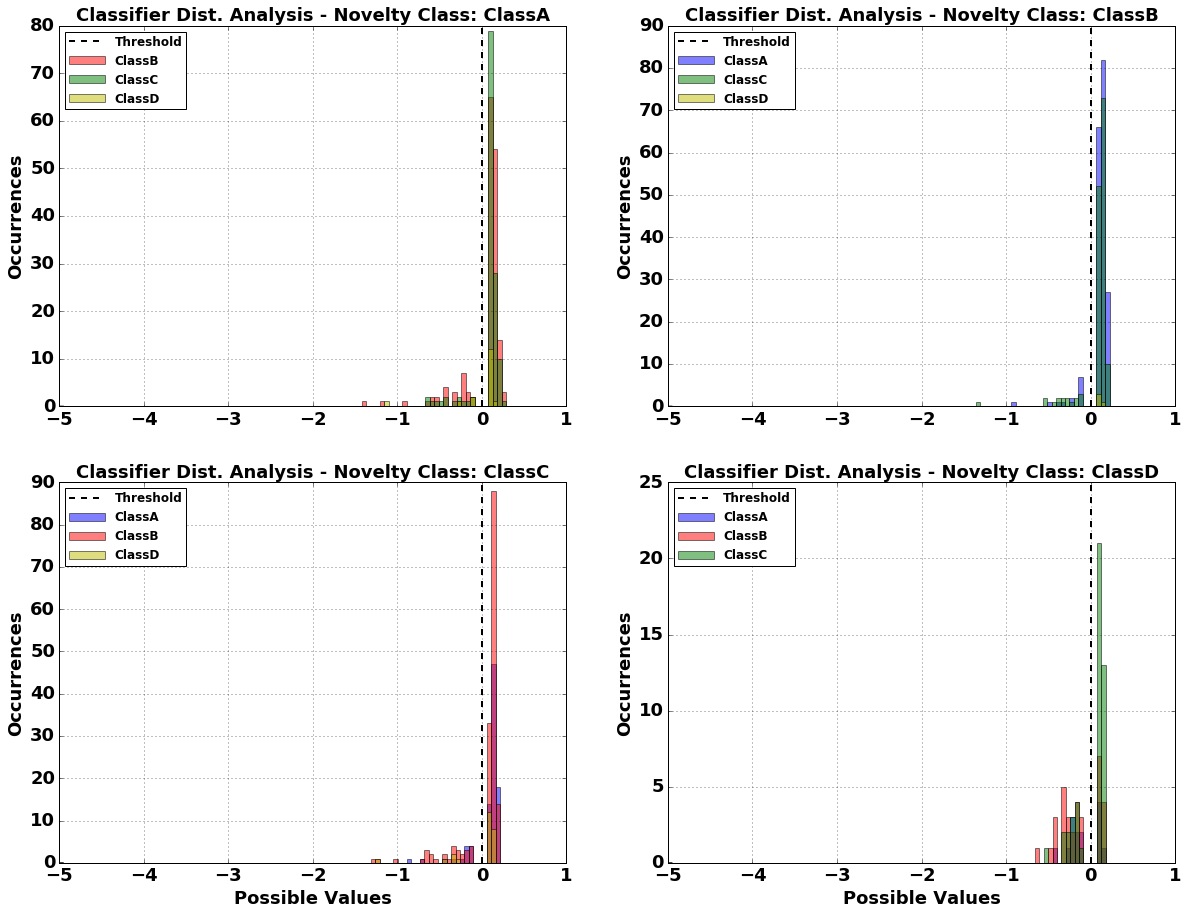

In [132]:
from Functions import StatFunctions as stats

# Read log files
from Functions import LogFunctions as log
mlog = log.LogInformation()
log_entries = mlog.RecoverLogEntries("NoveltyDetection")

choose_date = '2016_07_13_19_20_57'
choose_nu = 0.01
choose_fold = 0

n_bins = 100

for log_id, log_entry in enumerate(log_entries):
    if log_entries[log_id]['package'] != 'PCASingleClassSVM':
        continue
    if log_entries[log_id]['date'] != choose_date:
        continue
    print 'Analysing train performed in %s and for %s analysis'%(
        log_entries[log_id]['date'],log_entries[log_id]['package'])

    # Read train info file
    train_info_name = '%s/train_info_files/%s_train_info.jbl'%(
        result_analysis_path,log_entries[log_id]['date'])
    
    # check if the train file exists
    if(not os.path.exists(train_info_name)):
        print 'The file %s does not exist, please create it...'%(train_info_name)
    else:
        [train_info] = joblib.load(train_info_name)
        class_info_name = result_analysis_path+'/classifiers_files'+'/'+log_entries[log_id]['date']+'_classifiers.jbl'
        [classifiers] = joblib.load(class_info_name)
        
        fig, subplot_array = plt.subplots(nrows=2, ncols=2,figsize=(20,15))
        m_colors = ['b', 'r', 'g', 'y']
        
        for novelty_class, novelty_label in enumerate(class_labels):
            ax = plt.subplot(2,2,novelty_class+1)
            m_fontsize = 18
            plt.title('Classifier Dist. Analysis - Novelty Class: '+novelty_label, fontsize= m_fontsize, fontweight="bold")
            if novelty_class > 1:
                plt.xlabel('Possible Values', fontsize= m_fontsize, fontweight="bold")
            plt.ylabel('Occurrences', fontsize= m_fontsize, fontweight="bold")
            
            #data vectors
            known_data = {};
            # known classes loop
            for known_class, known_label in enumerate(class_labels):
                if known_class == novelty_class:continue
                # known class run loop
                for irun in range(len(data[known_class])):
                    if len(known_data) == 0:
                        known_data = data[known_class][irun]['Signal']
                        known_trgt = (known_class)*np.ones(data[known_class][irun]['Signal'].shape[1])
                    else:
                        known_data = np.append(known_data,data[known_class][irun]['Signal'],axis=1)
                        known_trgt = np.append(known_trgt,(known_class)*np.ones(
                                data[known_class][irun]['Signal'].shape[1]),axis=0)
            known_data = known_data.transpose()
    
            for ifold in range(len(train_info['CVO_%s'%(novelty_label)])):
                if ifold != choose_fold: continue
                train_id, test_id = train_info['CVO_%s'%(novelty_label)][ifold]
                
                # normalize data based in train set
                if train_info['norm'] == 'mapstd':
                    scaler = preprocessing.StandardScaler().fit(known_data[train_id,:])
                elif train_info['norm'] == 'mapstd_rob':
                    scaler = preprocessing.RobustScaler().fit(known_data[train_id,:])
                elif train_info['norm'] == 'mapminmax':
                    scaler = preprocessing.MinMaxScaler().fit(known_data[train_id,:])
                norm_known_data = scaler.transform(known_data)
        
                pca = PCA(n_components=train_info['n_pcas'])
                norm_known_data = pca.fit(norm_known_data[train_id,:]).transform(norm_known_data)
        
                for nu_id, nu_value in enumerate(train_info['nu_values']):
                    if nu_value != choose_nu: continue
                    distance = {}
                    for known_class, known_label in enumerate(class_labels):
                        if known_class == novelty_class: continue
                        distance[known_class-(known_class>novelty_class)] = (
                            classifiers[novelty_class][ifold][nu_value][known_label].decision_function(
                                norm_known_data[known_trgt==known_class,:]))
                        great_distance_ids = (np.absolute(
                                distance[known_class-(known_class>novelty_class)])>0.1)
                        distance[known_class-(known_class>novelty_class)] = (
                        distance[known_class-(known_class>novelty_class)][great_distance_ids])
                        
                    
                    m_min = -5.0
                    m_max = np.max([distance[0].max(),distance[1].max(),distance[2].max()])
                    #m_min = np.min([distance[0].min(),distance[1].min(),distance[2].min()])
                    #m_max = -0.5
                    
                    m_bins = np.linspace(m_min, m_max,n_bins)
                    
                    for known_class, known_label in enumerate(class_labels):
                        if known_class == novelty_class: continue
                        n1, bins, patches = plt.hist(distance[known_class-(known_class>novelty_class)],
                                                     bins=m_bins,fc=m_colors[known_class],alpha=0.5,
                                                     label=known_label)
                    
                    plt.grid()
                    ymin, ymax = ax.get_ylim()
                    xmin, xmax = ax.get_xlim()
                    x = np.zeros(50)
                    y = np.linspace(ymin,ymax,50)
                    plt.plot(x,y,ls='--',color= 'k', label='Threshold')
                    plt.legend(loc='best')
                    
        pict_name = ('%s/%s_%s_dist_distance_known_events_for_known_classifiers_%i_fold_%f_nu.pdf')%(
            picts_base_name,log_entries[log_id]['date'],log_entries[log_id]['package'],choose_fold, choose_nu)
        plt.savefig(pict_name)                   

This plot should be analysed

### Events Distance Distributions
This plot will express the distance between regular unknown events and separating hyperplane (known classifiers)


Analysing train performed in 2016_07_13_19_20_57 and for PCASingleClassSVM analysis


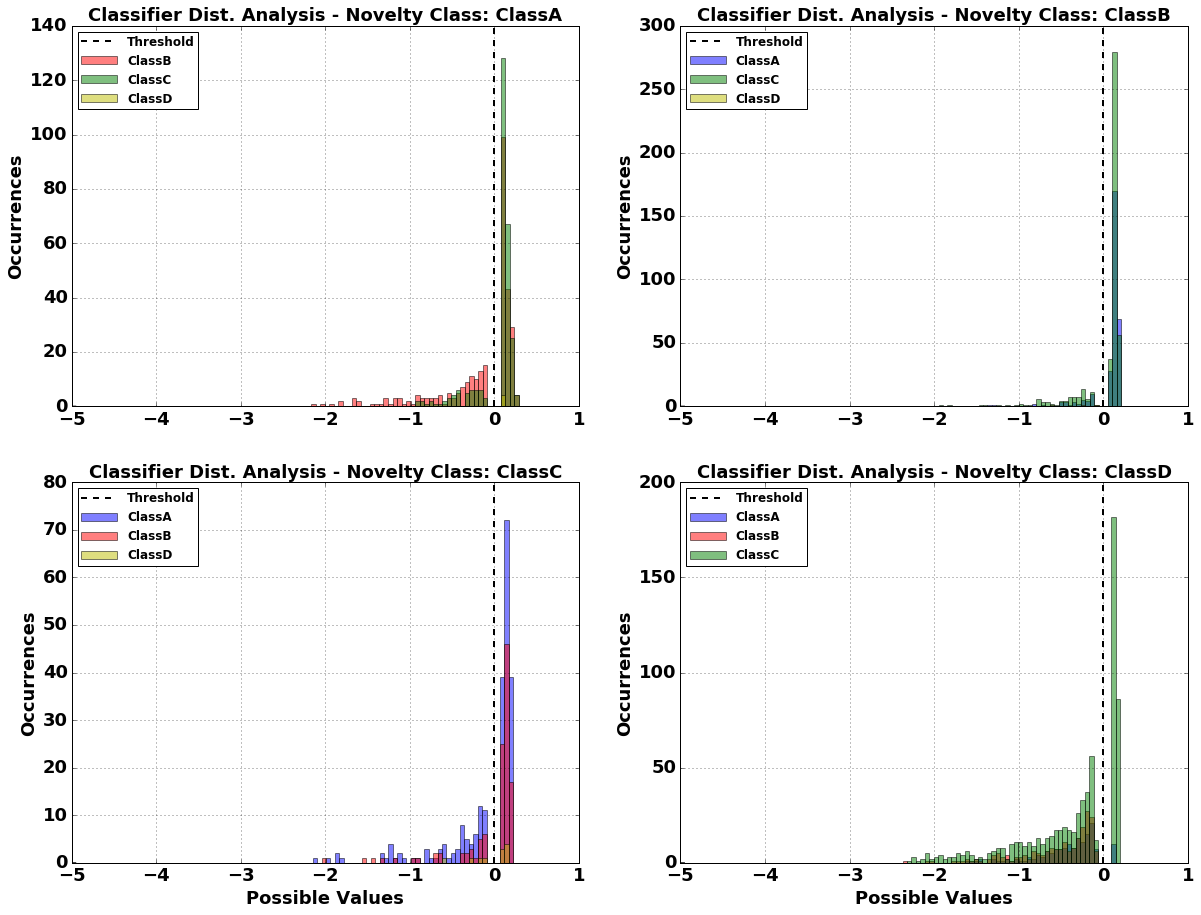

In [138]:
from Functions import StatFunctions as stats

# Read log files
from Functions import LogFunctions as log
mlog = log.LogInformation()
log_entries = mlog.RecoverLogEntries("NoveltyDetection")

choose_date = '2016_07_13_19_20_57'
choose_nu = 0.01
choose_fold = 0

n_bins = 100

for log_id, log_entry in enumerate(log_entries):
    if log_entries[log_id]['package'] != 'PCASingleClassSVM':
        continue
    if log_entries[log_id]['date'] != choose_date:
        continue
    print 'Analysing train performed in %s and for %s analysis'%(
        log_entries[log_id]['date'],log_entries[log_id]['package'])

    # Read train info file
    train_info_name = '%s/train_info_files/%s_train_info.jbl'%(
        result_analysis_path,log_entries[log_id]['date'])
    
    # check if the train file exists
    if(not os.path.exists(train_info_name)):
        print 'The file %s does not exist, please create it...'%(train_info_name)
    else:
        [train_info] = joblib.load(train_info_name)
        class_info_name = result_analysis_path+'/classifiers_files'+'/'+log_entries[log_id]['date']+'_classifiers.jbl'
        [classifiers] = joblib.load(class_info_name)
        
        fig, subplot_array = plt.subplots(nrows=2, ncols=2,figsize=(20,15))
        m_colors = ['b', 'r', 'g', 'y']
        
        for novelty_class, novelty_label in enumerate(class_labels):
            ax = plt.subplot(2,2,novelty_class+1)
            m_fontsize = 18
            plt.title('Classifier Dist. Analysis - Novelty Class: '+novelty_label, fontsize= m_fontsize, fontweight="bold")
            if novelty_class > 1:
                plt.xlabel('Possible Values', fontsize= m_fontsize, fontweight="bold")
            plt.ylabel('Occurrences', fontsize= m_fontsize, fontweight="bold")
            
            #data vectors
            known_data = {};
            # known classes loop
            for known_class, known_label in enumerate(class_labels):
                if known_class == novelty_class:continue
                # known class run loop
                for irun in range(len(data[known_class])):
                    if len(known_data) == 0:
                        known_data = data[known_class][irun]['Signal']
                        known_trgt = (known_class)*np.ones(data[known_class][irun]['Signal'].shape[1])
                    else:
                        known_data = np.append(known_data,data[known_class][irun]['Signal'],axis=1)
                        known_trgt = np.append(known_trgt,(known_class)*np.ones(
                                data[known_class][irun]['Signal'].shape[1]),axis=0)
            known_data = known_data.transpose()
            
            novelty_data = {};
            for irun in range(len(data[novelty_class])):
                if len(novelty_data) == 0:
                    novelty_data = data[novelty_class][irun]['Signal']
                else:
                    novelty_data = np.append(novelty_data,data[novelty_class][irun]['Signal'],axis=1)
            novelty_data = novelty_data.transpose()
            
    
            for ifold in range(len(train_info['CVO_%s'%(novelty_label)])):
                if ifold != choose_fold: continue
                train_id, test_id = train_info['CVO_%s'%(novelty_label)][ifold]
                
                # normalize data based in train set
                if train_info['norm'] == 'mapstd':
                    scaler = preprocessing.StandardScaler().fit(known_data[train_id,:])
                elif train_info['norm'] == 'mapstd_rob':
                    scaler = preprocessing.RobustScaler().fit(known_data[train_id,:])
                elif train_info['norm'] == 'mapminmax':
                    scaler = preprocessing.MinMaxScaler().fit(known_data[train_id,:])
                norm_known_data = scaler.transform(known_data)
                norm_novelty_data = scaler.transform(novelty_data)
        
                pca = PCA(n_components=train_info['n_pcas'])
                pca.fit(norm_known_data[train_id,:])
                norm_novelty_data = pca.transform(norm_novelty_data)
        
                for nu_id, nu_value in enumerate(train_info['nu_values']):
                    if nu_value != choose_nu: continue
                    distance = {}
                    for known_class, known_label in enumerate(class_labels):
                        if known_class == novelty_class: continue
                        distance[known_class-(known_class>novelty_class)] = (
                            classifiers[novelty_class][ifold][nu_value][known_label].decision_function(
                            norm_novelty_data))
                        great_distance_ids = (np.absolute(
                                distance[known_class-(known_class>novelty_class)])>0.1)
                        distance[known_class-(known_class>novelty_class)] = (
                        distance[known_class-(known_class>novelty_class)][great_distance_ids])
                        
                    
                    
                    m_max = np.max([distance[0].max(),distance[1].max(),distance[2].max()])
                    #m_min = np.min([distance[0].min(),distance[1].min(),distance[2].min()])
                    #m_max = -0.5
                    m_min = -5.0
                    
                    m_bins = np.linspace(m_min, m_max,n_bins)
                    
                    for known_class, known_label in enumerate(class_labels):
                        if known_class == novelty_class: continue
                        n1, bins, patches = plt.hist(distance[known_class-(known_class>novelty_class)],
                                                     bins=m_bins,fc=m_colors[known_class],alpha=0.5,
                                                     label=known_label)
                    
                    plt.grid()
                    ymin, ymax = ax.get_ylim()
                    xmin, xmax = ax.get_xlim()
                    x = np.zeros(50)
                    y = np.linspace(ymin,ymax,50)
                    plt.plot(x,y,ls='--',color= 'k', label='Threshold')
                    plt.legend(loc='best')
                    
        pict_name = ('%s/%s_%s_dist_distance_unknown_events_for_known_classifiers_%i_fold_%f_nu.pdf')%(
            picts_base_name,log_entries[log_id]['date'],log_entries[log_id]['package'],choose_fold, choose_nu)
        plt.savefig(pict_name)                   

this plot should analysed

### Events Distance Distributions
This plot will express the distance between regular unknown events and separating hyperplane (novelty detector)


Analysing train performed in 2016_07_13_19_20_57 and for PCASingleClassSVM analysis


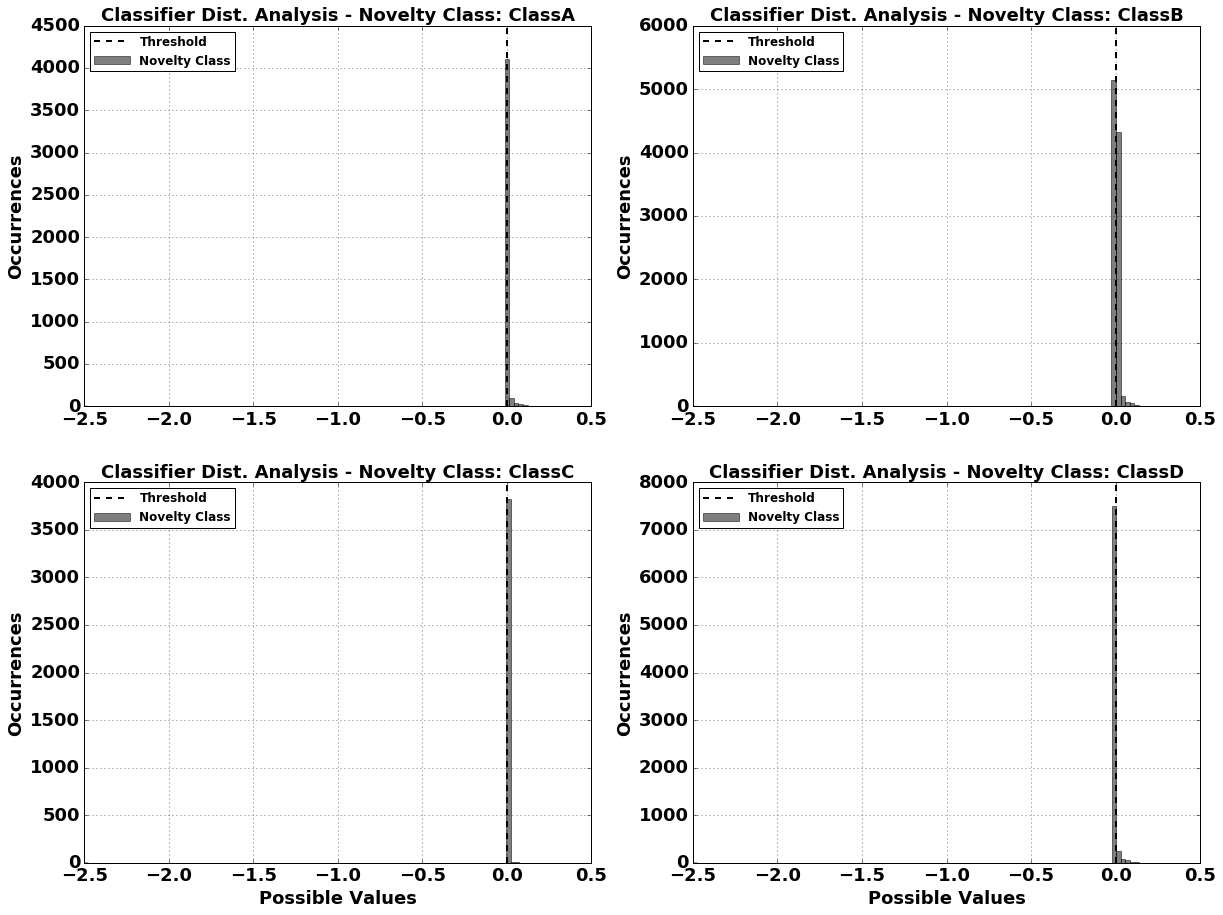

In [144]:
from Functions import StatFunctions as stats

# Read log files
from Functions import LogFunctions as log
mlog = log.LogInformation()
log_entries = mlog.RecoverLogEntries("NoveltyDetection")

choose_date = '2016_07_13_19_20_57'
choose_nu = 0.01
choose_fold = 0

n_bins = 100

for log_id, log_entry in enumerate(log_entries):
    if log_entries[log_id]['package'] != 'PCASingleClassSVM':
        continue
    if log_entries[log_id]['date'] != choose_date:
        continue
    print 'Analysing train performed in %s and for %s analysis'%(
        log_entries[log_id]['date'],log_entries[log_id]['package'])

    # Read train info file
    train_info_name = '%s/train_info_files/%s_train_info.jbl'%(
        result_analysis_path,log_entries[log_id]['date'])
    
    # check if the train file exists
    if(not os.path.exists(train_info_name)):
        print 'The file %s does not exist, please create it...'%(train_info_name)
    else:
        [train_info] = joblib.load(train_info_name)
        class_info_name = result_analysis_path+'/classifiers_files'+'/'+log_entries[log_id]['date']+'_classifiers.jbl'
        [classifiers] = joblib.load(class_info_name)
        
        fig, subplot_array = plt.subplots(nrows=2, ncols=2,figsize=(20,15))
        m_colors = ['b', 'r', 'g', 'y']
        
        for novelty_class, novelty_label in enumerate(class_labels):
            ax = plt.subplot(2,2,novelty_class+1)
            m_fontsize = 18
            plt.title('Classifier Dist. Analysis - Novelty Class: '+novelty_label, fontsize= m_fontsize, fontweight="bold")
            if novelty_class > 1:
                plt.xlabel('Possible Values', fontsize= m_fontsize, fontweight="bold")
            plt.ylabel('Occurrences', fontsize= m_fontsize, fontweight="bold")
            
            #data vectors
            known_data = {};
            # known classes loop
            for known_class, known_label in enumerate(class_labels):
                if known_class == novelty_class:continue
                # known class run loop
                for irun in range(len(data[known_class])):
                    if len(known_data) == 0:
                        known_data = data[known_class][irun]['Signal']
                        known_trgt = (known_class)*np.ones(data[known_class][irun]['Signal'].shape[1])
                    else:
                        known_data = np.append(known_data,data[known_class][irun]['Signal'],axis=1)
                        known_trgt = np.append(known_trgt,(known_class)*np.ones(
                                data[known_class][irun]['Signal'].shape[1]),axis=0)
            known_data = known_data.transpose()
            
            novelty_data = {};
            for irun in range(len(data[novelty_class])):
                if len(novelty_data) == 0:
                    novelty_data = data[novelty_class][irun]['Signal']
                else:
                    novelty_data = np.append(novelty_data,data[novelty_class][irun]['Signal'],axis=1)
            novelty_data = novelty_data.transpose()
            
    
            for ifold in range(len(train_info['CVO_%s'%(novelty_label)])):
                if ifold != choose_fold: continue
                train_id, test_id = train_info['CVO_%s'%(novelty_label)][ifold]
                
                # normalize data based in train set
                if train_info['norm'] == 'mapstd':
                    scaler = preprocessing.StandardScaler().fit(known_data[train_id,:])
                elif train_info['norm'] == 'mapstd_rob':
                    scaler = preprocessing.RobustScaler().fit(known_data[train_id,:])
                elif train_info['norm'] == 'mapminmax':
                    scaler = preprocessing.MinMaxScaler().fit(known_data[train_id,:])
                norm_known_data = scaler.transform(known_data)
                norm_novelty_data = scaler.transform(novelty_data)
        
                pca = PCA(n_components=train_info['n_pcas'])
                norm_known_data = pca.fit(norm_known_data[train_id,:]).transform(norm_known_data)
                norm_novelty_data = pca.transform(norm_novelty_data)
        
                for nu_id, nu_value in enumerate(train_info['nu_values']):
                    if nu_value != choose_nu: continue
                    distance = (classifiers[novelty_class][ifold][nu_value]
                                ['NoveltyDetector'].decision_function(norm_novelty_data))
                                            
                    m_max = distance.max()
                    #m_min = distance.min()
                    #m_max = -0.5
                    m_min = -2.5
                    
                    m_bins = np.linspace(m_min, m_max,n_bins)
                    
                    n1, bins, patches = plt.hist(distance,bins=m_bins,fc='k',alpha=0.5,label='Novelty Class')
                        
                    plt.grid()
                    ymin, ymax = ax.get_ylim()
                    xmin, xmax = ax.get_xlim()
                    x = np.zeros(50)
                    y = np.linspace(ymin,ymax,50)
                    plt.plot(x,y,ls='--',color= 'k', label='Threshold')
                    plt.legend(loc='best')
                    
        pict_name = ('%s/%s_%s_dist_distance_unknown_events_for_novelty_detector_%i_fold_%f_nu.pdf')%(
            picts_base_name,log_entries[log_id]['date'],log_entries[log_id]['package'],choose_fold, choose_nu)
        plt.savefig(pict_name)                   

This plot should be analysed

### Events Distance Distributions
This plot will express the distance between regular known events and separating hyperplane (novelty detector)


Analysing train performed in 2016_07_13_19_20_57 and for PCASingleClassSVM analysis


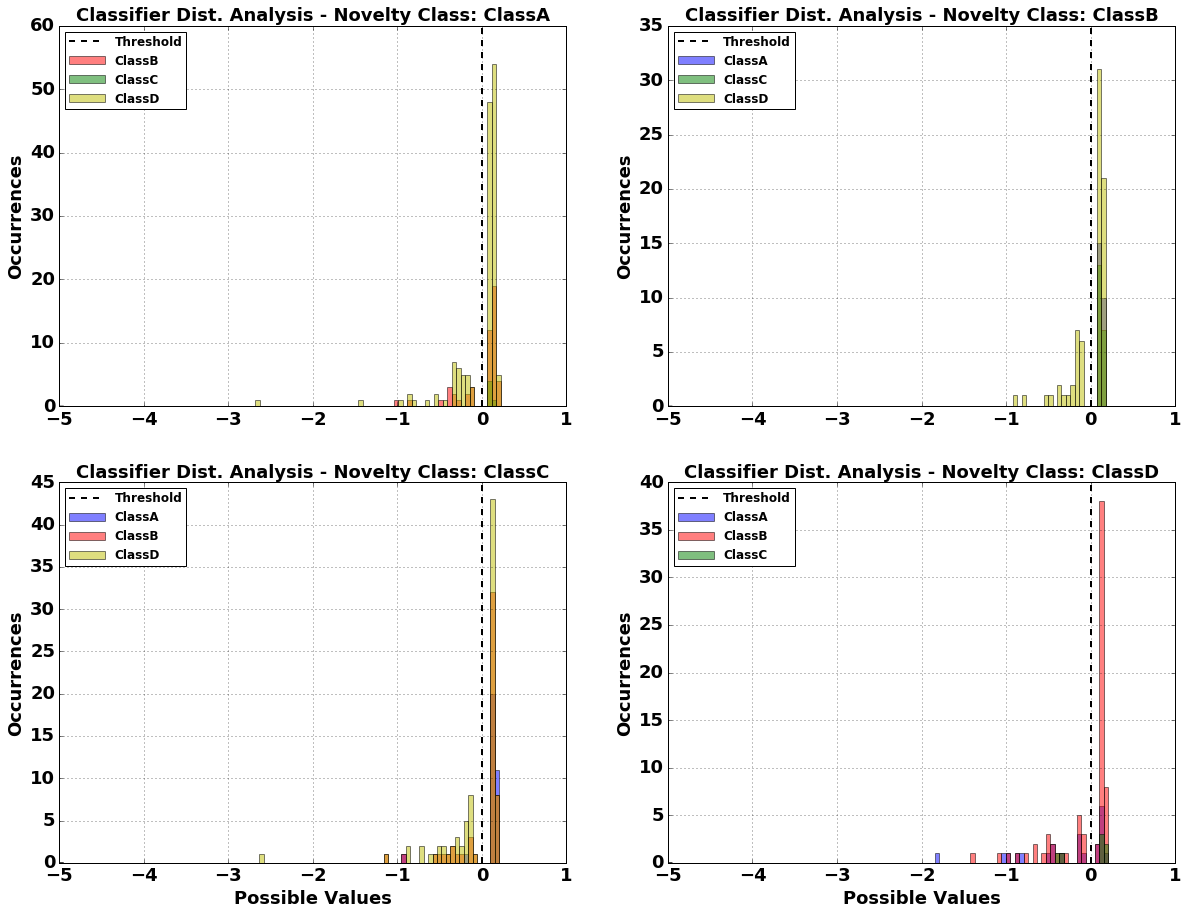

In [150]:
from Functions import StatFunctions as stats

# Read log files
from Functions import LogFunctions as log
mlog = log.LogInformation()
log_entries = mlog.RecoverLogEntries("NoveltyDetection")

choose_date = '2016_07_13_19_20_57'
choose_nu = 0.01
choose_fold = 0

n_bins = 100

for log_id, log_entry in enumerate(log_entries):
    if log_entries[log_id]['package'] != 'PCASingleClassSVM':
        continue
    if log_entries[log_id]['date'] != choose_date:
        continue
    print 'Analysing train performed in %s and for %s analysis'%(
        log_entries[log_id]['date'],log_entries[log_id]['package'])

    # Read train info file
    train_info_name = '%s/train_info_files/%s_train_info.jbl'%(
        result_analysis_path,log_entries[log_id]['date'])
    
    # check if the train file exists
    if(not os.path.exists(train_info_name)):
        print 'The file %s does not exist, please create it...'%(train_info_name)
    else:
        [train_info] = joblib.load(train_info_name)
        class_info_name = result_analysis_path+'/classifiers_files'+'/'+log_entries[log_id]['date']+'_classifiers.jbl'
        [classifiers] = joblib.load(class_info_name)
        
        fig, subplot_array = plt.subplots(nrows=2, ncols=2,figsize=(20,15))
        m_colors = ['b', 'r', 'g', 'y']
        
        for novelty_class, novelty_label in enumerate(class_labels):
            ax = plt.subplot(2,2,novelty_class+1)
            m_fontsize = 18
            plt.title('Classifier Dist. Analysis - Novelty Class: '+novelty_label, fontsize= m_fontsize, fontweight="bold")
            if novelty_class > 1:
                plt.xlabel('Possible Values', fontsize= m_fontsize, fontweight="bold")
            plt.ylabel('Occurrences', fontsize= m_fontsize, fontweight="bold")
            
            #data vectors
            known_data = {};
            # known classes loop
            for known_class, known_label in enumerate(class_labels):
                if known_class == novelty_class:continue
                # known class run loop
                for irun in range(len(data[known_class])):
                    if len(known_data) == 0:
                        known_data = data[known_class][irun]['Signal']
                        known_trgt = (known_class)*np.ones(data[known_class][irun]['Signal'].shape[1])
                    else:
                        known_data = np.append(known_data,data[known_class][irun]['Signal'],axis=1)
                        known_trgt = np.append(known_trgt,(known_class)*np.ones(
                                data[known_class][irun]['Signal'].shape[1]),axis=0)
            known_data = known_data.transpose()
            
            novelty_data = {};
            for irun in range(len(data[novelty_class])):
                if len(novelty_data) == 0:
                    novelty_data = data[novelty_class][irun]['Signal']
                else:
                    novelty_data = np.append(novelty_data,data[novelty_class][irun]['Signal'],axis=1)
            novelty_data = novelty_data.transpose()
            
    
            for ifold in range(len(train_info['CVO_%s'%(novelty_label)])):
                if ifold != choose_fold: continue
                train_id, test_id = train_info['CVO_%s'%(novelty_label)][ifold]
                
                # normalize data based in train set
                if train_info['norm'] == 'mapstd':
                    scaler = preprocessing.StandardScaler().fit(known_data[train_id,:])
                elif train_info['norm'] == 'mapstd_rob':
                    scaler = preprocessing.RobustScaler().fit(known_data[train_id,:])
                elif train_info['norm'] == 'mapminmax':
                    scaler = preprocessing.MinMaxScaler().fit(known_data[train_id,:])
                norm_known_data = scaler.transform(known_data)
                norm_novelty_data = scaler.transform(novelty_data)
        
                pca = PCA(n_components=train_info['n_pcas'])
                norm_known_data = pca.fit(norm_known_data[train_id,:]).transform(norm_known_data)
                norm_novelty_data = pca.transform(norm_novelty_data)
        
                for nu_id, nu_value in enumerate(train_info['nu_values']):
                    if nu_value != choose_nu: continue
                    distance = {}
                    for known_class, known_label in enumerate(class_labels):
                        if known_class == novelty_class: continue
                        distance[known_class-(known_class>novelty_class)] = (
                            classifiers[novelty_class][ifold][nu_value]['NoveltyDetector'].decision_function(
                            norm_known_data[known_trgt==known_class,:]))
                        great_distance_ids = (np.absolute(
                                distance[known_class-(known_class>novelty_class)])>0.1)
                        distance[known_class-(known_class>novelty_class)] = (
                        distance[known_class-(known_class>novelty_class)][great_distance_ids])
                        
                    m_max = np.max([distance[0].max(),distance[1].max(),distance[2].max()])
                    #m_min = np.min([distance[0].min(),distance[1].min(),distance[2].min()])
                    #m_max = -0.5
                    m_min = -5.0
                    
                    m_bins = np.linspace(m_min, m_max,n_bins)
                    
                    for known_class, known_label in enumerate(class_labels):
                        if known_class == novelty_class: continue
                        n1, bins, patches = plt.hist(distance[known_class-(known_class>novelty_class)],
                                                     bins=m_bins,fc=m_colors[known_class],alpha=0.5,
                                                     label=known_label)
                    
                    plt.grid()
                    ymin, ymax = ax.get_ylim()
                    xmin, xmax = ax.get_xlim()
                    x = np.zeros(50)
                    y = np.linspace(ymin,ymax,50)
                    plt.plot(x,y,ls='--',color= 'k', label='Threshold')
                    plt.legend(loc='best')
                    
        pict_name = ('%s/%s_%s_dist_distance_known_events_for_novelty_detector_%i_fold_%f_nu.pdf')%(
            picts_base_name,log_entries[log_id]['date'],log_entries[log_id]['package'],choose_fold, choose_nu)
        plt.savefig(pict_name)                   